## Темы, которые разбираем в данном ноутбуке:

* ### Феномен Бергера

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import os

In [ ]:
# импортируем данные формата brainvision
raw = mne.io.read_raw_brainvision("C:\Code\Math_for_Med\LEMON\sub-010002.vhdr", preload=True)
raw

In [ ]:
raw.plot()

Using qt as 2D backend.


Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
[np.str_('F8')]


In [ ]:
# создаём переменную channels с именами каналов
channels = raw.ch_names
channels

In [ ]:
# выбираем нужные нам для эксперимента каналы
raw_experimental = raw.copy().pick_channels(['O1','O2','Oz','F4','F8']) # создание копии ЭЭГ, содержащей только 5 каналов
raw_experimental_psd = raw_experimental.compute_psd(fmin = 2, fmax = 30)
# смотрим что получилось
raw_experimental.plot()
raw_experimental_psd.plot()


In [ ]:
# Создаём более наглядный график с подписями, используя matplotlob
psds, freqs = raw_experimental_psd.get_data(return_freqs=True) # вытаскиваем мощности и частоты (оси y и x)
names = raw_experimental_psd.ch_names # вытаскиваем названия каналов (линий)

fig, ax = plt.subplots(figsize=(10, 6))

# Создаём цикл,чтобы вручную пересчитать мощности для плотности 
# Взятие логарифма необходимо, чтобы перевести вольты в децибелы
for i in range(len(names)):
    power_db = 10 * np.log10(psds[i])
    ax.plot(freqs, power_db, label=names[i])

ax.set_title('Power spectral density')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB/Hz)')
ax.legend() 
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [10]:
# Очищаем ЭЭГ от частот ниже 1 Гц (шум)
raw_experimental = raw_experimental.filter(l_freq = 1, h_freq = 40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 8251 samples (3.300 s)



### Метки в данных

Исследователи отмечают на ЭЭГ события - совершенные пацинетом движения, поломка соединения и так далее

Нам важны 2 события: **1 - глаза открыл, 2 - глаза закры**

* *В случае данного исследования в метаданных, к сожалению, не было отмечено какие события какому действию соотвествуют. Такое бывает. Инофрмацию о соотвествии действия обозначению на ЭЭГ брал из статьи, написанно на основе данных с анализируемого датасета*

* **Статья: https://www.nature.com/articles/sdata2018308**

<a href="../assets/proof.png">
  <img src="../assets/proof.png" width="500" alt="Click">
</a>

In [11]:
# смотрим, какие маркёры в данных и сверяем с кодом событий из статьи
print(set(raw.annotations.description))

{np.str_('Stimulus/S210'), np.str_('Stimulus/S200'), np.str_('Comment/no USB Connection to actiCAP'), np.str_('Stimulus/S  1')}


In [ ]:
# создаём 2 объекта
# events - массив numpy, содержащий все события, отмечченные на ЭЭГ
# evene_id - словарь, показывающий 
events, event_id = mne.events_from_annotations(raw)
print(events[:5])
print(event_id)


Used Annotations descriptions: [np.str_('Comment/no USB Connection to actiCAP'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S200'), np.str_('Stimulus/S210')]
[[    0     0 10001]
 [ 9979     0     1]
 [15938     0     1]
 [15962     0   210]
 [20962     0   210]]
{np.str_('Comment/no USB Connection to actiCAP'): 10001, np.str_('Stimulus/S  1'): 1, np.str_('Stimulus/S200'): 200, np.str_('Stimulus/S210'): 210}


In [ ]:
# выбираем из словаря всех событий только те, которые нам нужны, и переобозначаем их
event_dict =  {'Open': 200, 'Closed': 210}

In [ ]:
# создаём эпохи
epochs_occipital = mne.Epochs (raw_occipital_filtered, events, event_id = event_dict, preload=True)

Not setting metadata
480 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 480 events and 1751 original time points ...


0 bad epochs dropped


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


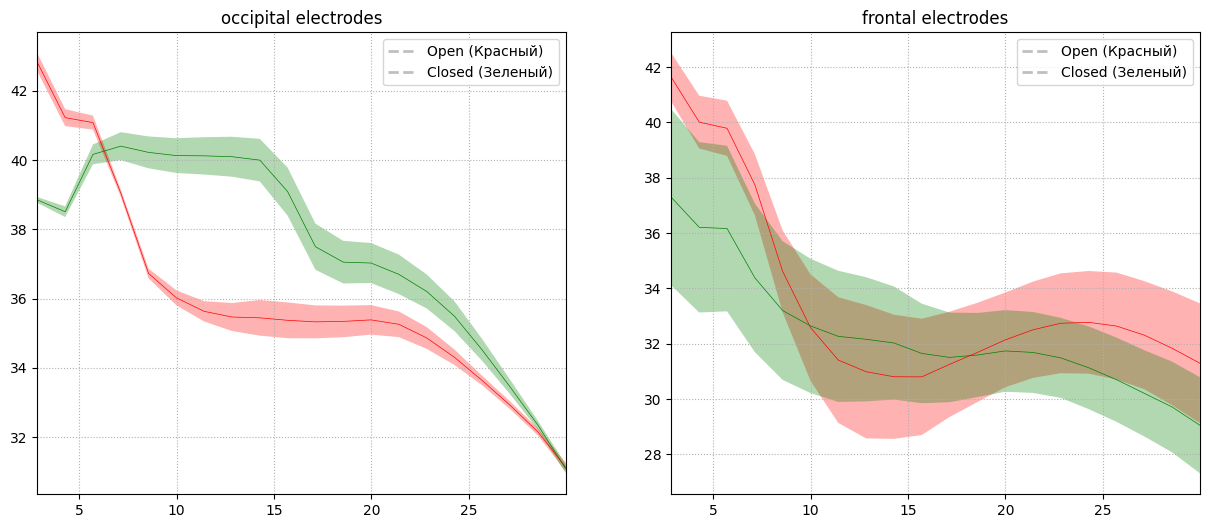

In [ ]:
# строим графики, чтобы увидеть феномен Бергера
fig, ax = plt.subplots(1,2, figsize = (15,6))

# строим график спектральной плотности для затылочных электродов
epochs_occipital['Open'].compute_psd(fmin=2, fmax=30, picks = ['O1','O2','Oz']).plot(axes = ax[0], color = 'red', average=True)
epochs_occipital['Closed'].compute_psd(fmin=2, fmax=30, picks = ['O1','O2','Oz']).plot(axes = ax[0], color = 'green', average=True)

ax[0].set_title('occipital electrodes')
ax[0].legend(['Open (Красный)', 'Closed (Зеленый)'])

# строим график спектральной плотности для лобных электродов
epochs_occipital['Open'].compute_psd(fmin=2, fmax=30, picks = ['F4','F8']).plot(axes = ax[1], color = 'red', average=True)
epochs_occipital['Closed'].compute_psd(fmin=2, fmax=30, picks = ['F4','F8']).plot(axes = ax[1], color = 'green', average=True)

ax[1].set_title('frontal electrodes')
ax[1].legend(['Open (Красный)', 'Closed (Зеленый)'])

plt.show()